In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
from scipy.stats import iqr
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
sns.set(style="whitegrid")

In [2]:
df=pd.read_csv("dataSet.csv")

In [3]:
df.shape

(6362620, 11)

In [4]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

indicating that the dataset is complete and does not require imputation for any of its attributes. This absence of missing values is crucial for ensuring the reliability and completeness of the dataset during subsequent analyses.

In [8]:
df.duplicated().sum()

0

 This absence of duplicates is significant in maintaining the integrity and reliability of the dataset, ensuring that each transaction record is unique and preventing any potential distortions in the analysis due to redundant information.

### Explore the data

In [9]:
#Define custom colors
light_orange = '#ffd699'
light_red = '#ff9999'

In [10]:
unique_types = df['type'].unique();
type_counts = df['type'].value_counts()
type_counts

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Il existe cinq types distincts de transactions dans l'ensemble de données :
PAYMENT, TRANSFER, CASH_OUT, DEBIT et CASH_IN.

La répartition de ces types de transactions est la suivante :

CASH_OUT : 2 237 500 transactions

PAIEMENT : 2 151 495 transactions

CASH_IN : 1 399 284 transactions

TRANSFERT : 532 909 transactions

DÉBIT : 41 432 transactions

Ces informations fournissent un aperçu de la variété et de la prévalence des types de transactions au sein de l'ensemble de données. 

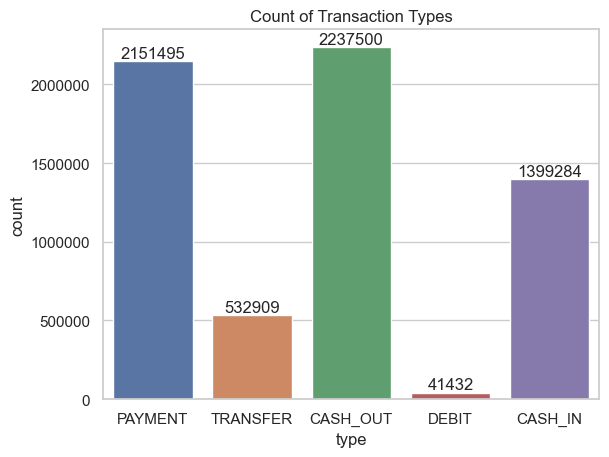

In [11]:
ax = sns.countplot(x='type',data=df)
plt.title('Count of Transaction Types')

for bars in ax.containers:
     ax.bar_label(bars, fmt='%d')
          
# Prevent scientific notation in tick labels
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.ticklabel_format(style='plain', axis='y')
plt.show()

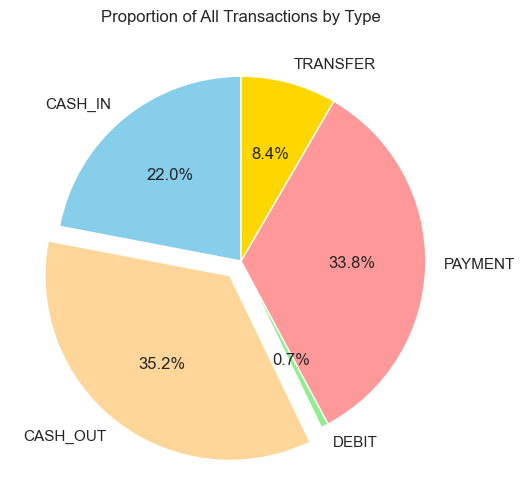

In [12]:
all_counts_by_type = df.groupby("type").size()
plt.figure(figsize=(6, 6))
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', light_orange, 'lightgreen', light_red, 'gold'], explode=(0, 0.1, 0, 0, 0))
plt.title('Proportion of All Transactions by Type')
plt.show()


Le graphique illustre la proportion de chaque type de transaction par rapport au nombre total de transactions.

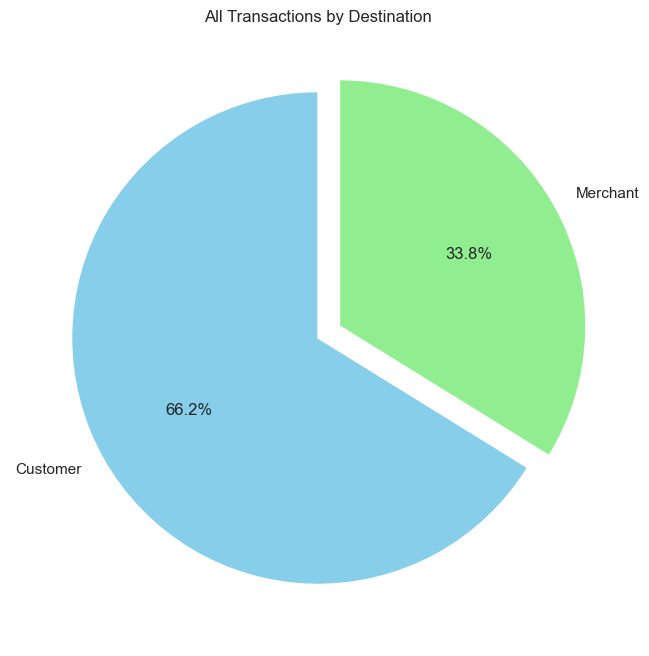

In [13]:
df_copy = df.copy();
df_copy['nameDest_first_letter'] = df_copy['nameDest'].str[0]
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('C', 'Customer')
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('M', 'Merchant')
all_by_dest = df_copy.groupby('nameDest_first_letter').size()

plt.figure(figsize=(8, 8))
plt.pie(all_by_dest, labels=all_by_dest.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'], explode=(0, 0.1))
plt.title('All Transactions by Destination')
plt.show()

Le graphique illustre la proportion de toutes les transactions par rapport à la destination
### 

In [14]:
fraud_count = df[df["isFraud"] == 1].shape[0]
non_fraud_count = df[df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraud_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraud_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


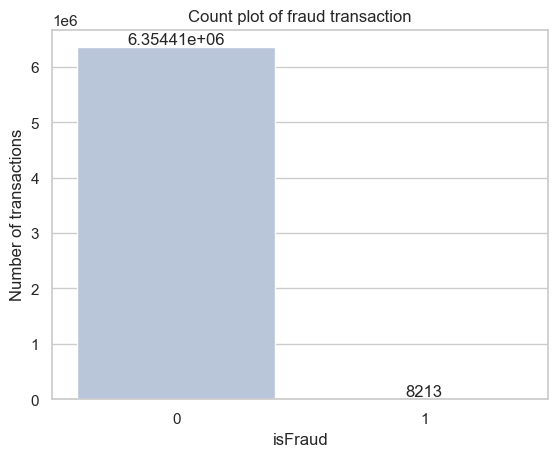

In [15]:
ax = sns.countplot(x='isFraud', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of fraud transaction')
plt.ylabel('Number of transactions')

del ax

Cette répartition très déséquilibrée, dans laquelle le nombre de transactions non frauduleuses dépasse largement le nombre de transactions frauduleuses, peut poser des problèmes lors de la formation du modèle. Il est crucial de remédier à ce déséquilibre de classe pour garantir que le modèle d'apprentissage automatique ne devienne pas biaisé en faveur de la classe majoritaire, conduisant à des performances sous-optimales dans l'identification de la classe minoritaire (transactions frauduleuses).
### 

In [16]:
total_transactions = fraud_count + non_fraud_count

fraud_percentage = (fraud_count / total_transactions) * 100
non_fraud_percentage = (non_fraud_count / total_transactions) * 100

print(f"Fraud Transactions percentage: {fraud_percentage:.2f}%")
print(f"Non-fraud Transactions percentage: {non_fraud_percentage:.2f}%")

Fraud Transactions percentage: 0.13%
Non-fraud Transactions percentage: 99.87%


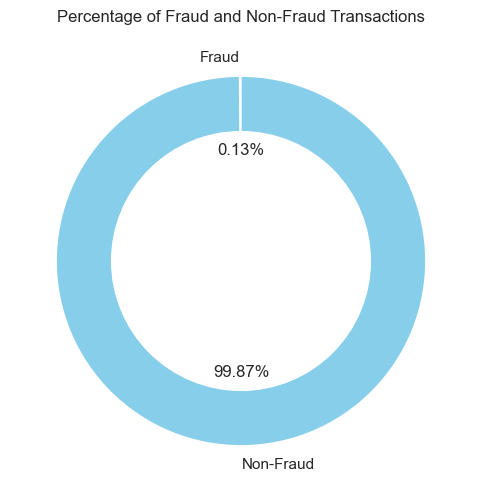

In [17]:
labels = ['Fraud', 'Non-Fraud']
sizes = [fraud_percentage, non_fraud_percentage]
colors = ['orange', 'skyblue']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Fraud and Non-Fraud Transactions')
plt.show()

Avec 99,87 % des transactions classées comme authentiques (6 354 407) et seulement 0,13 % (8 213) identifiées comme frauduleuses, une approche simpliste consistant à prédire aveuglément que toutes les transactions sont authentiques donnerait une précision de 99,8 %. Cette grande précision, motivée par la prédominance de transactions authentiques, souligne le défi posé par le déséquilibre des classes dans l’ensemble de données.
### 

type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


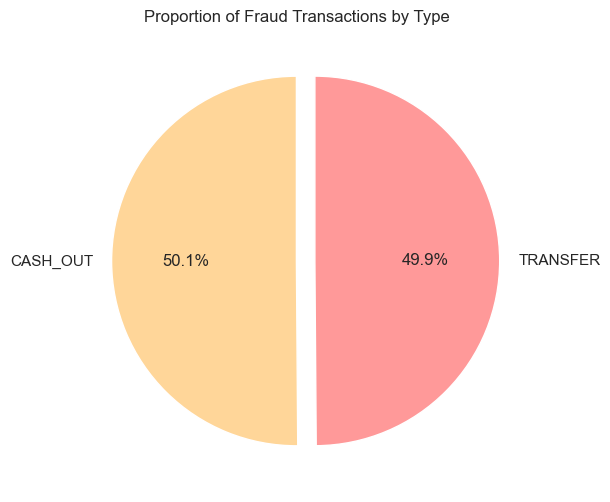

In [18]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_counts_by_type = fraud_transactions.groupby("type").size()
print(fraud_counts_by_type)

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts_by_type, labels=fraud_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Proportion of Fraud Transactions by Type')
plt.show()

Cette concentration de fraude dans les transactions CASH_OUT et TRANSFER suggère que ces types spécifiques peuvent être plus sensibles aux activités frauduleuses.
### 

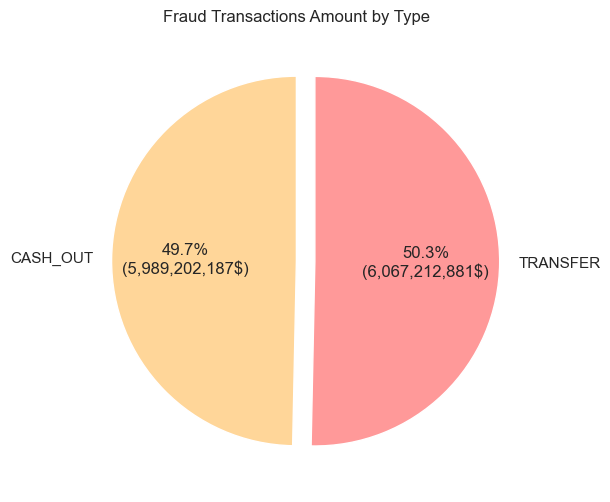

In [19]:
fraud_amounts_by_type = df[df["isFraud"] == 1].groupby("type")["amount"].sum() # Filters the DataFrame to include only fraud transactions.
#and then Groups these transactions by type and sums up the amounts for each type.
plt.figure(figsize=(6, 6))
plt.pie(fraud_amounts_by_type, labels=fraud_amounts_by_type.index, autopct=lambda p: f'{p:.1f}%\n({p * sum(fraud_amounts_by_type) / 100:,.0f}$)', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Fraud Transactions Amount by Type')
plt.show()

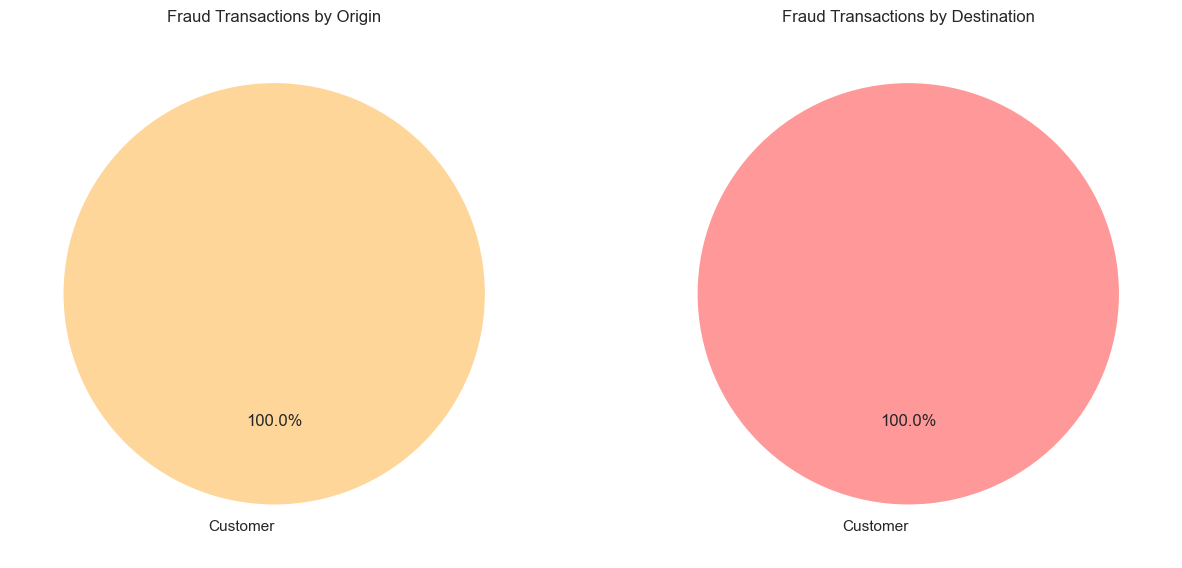

In [20]:
fraud_transactions = df[df['isFraud'] == 1].copy()
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrig'].str[0]
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest'].str[0]
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg_first_letter'].replace('C', 'Customer')
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest_first_letter'].replace('C', 'Customer')
fraud_by_name_orig_first_letter = fraud_transactions.groupby('nameOrg_first_letter').size()
fraud_by_name_dest_first_letter = fraud_transactions.groupby('nameDest_first_letter').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(fraud_by_name_orig_first_letter, labels=fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange])
axes[0].set_title('Fraud Transactions by Origin')

axes[1].pie(fraud_by_name_dest_first_letter, labels=fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_red])
axes[1].set_title('Fraud Transactions by Destination')

plt.show()

L'analyse des transactions frauduleuses révèle un schéma distinct : toutes les transactions frauduleuses impliquent des interactions entre les clients, à la fois en tant qu'initiateurs et destinataires. Cela implique que les activités frauduleuses, telles qu'identifiées dans l'ensemble de données, se produisent exclusivement dans le cadre de transactions impliquant des clients des deux côtés. Comprendre ces modèles est crucial pour affiner les stratégies de détection de la fraude et mettre en œuvre des mesures ciblées visant à renforcer la sécurité des transactions de client à client.
### 

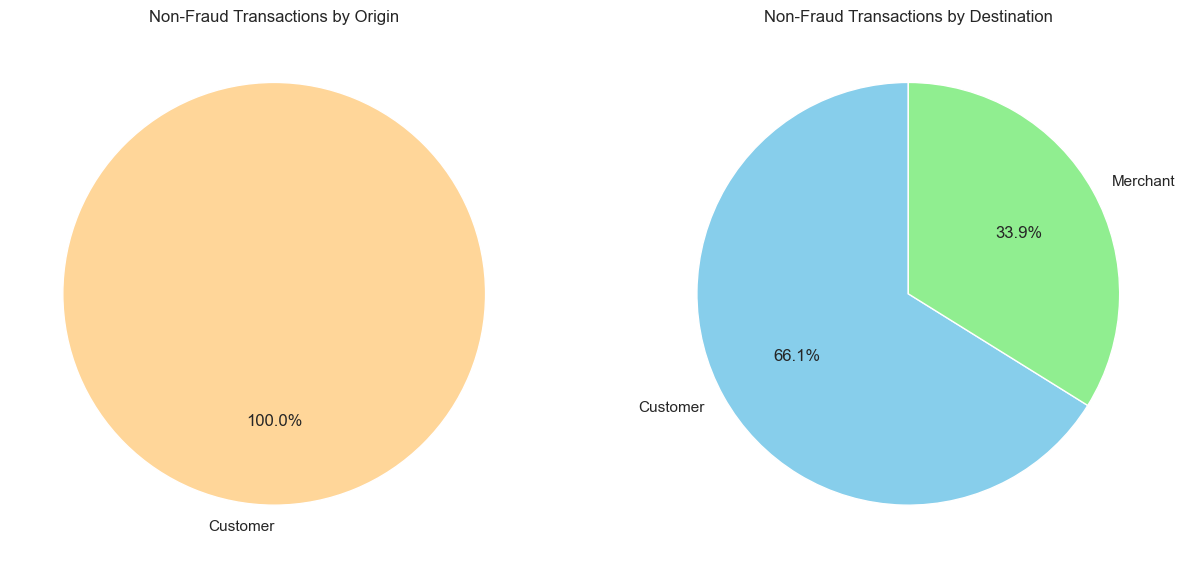

In [21]:
non_fraud_transactions = df[df['isFraud'] == 0].copy()
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrig'].str[0]
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest'].str[0]
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})

non_fraud_by_name_orig_first_letter = non_fraud_transactions.groupby('nameOrg_first_letter').size()
non_fraud_by_name_dest_first_letter = non_fraud_transactions.groupby('nameDest_first_letter').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Pie chart for Non-Fraud Transactions by Origin
axes[0].pie(non_fraud_by_name_orig_first_letter, labels=non_fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, 'lightcoral'])
axes[0].set_title('Non-Fraud Transactions by Origin')

# Pie chart for Non-Fraud Transactions by Destination
axes[1].pie(non_fraud_by_name_dest_first_letter, labels=non_fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[1].set_title('Non-Fraud Transactions by Destination')

plt.show()

In [22]:
pd.set_option('display.float_format', '{:,.1f}'.format)
print("Statistics on the amounts for non-fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 0].amount), "\n")
print("Statistics on the amounts for fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 1].amount), "\n")

Statistics on the amounts for non-fraud transactions:
 count    6,354,407.0
mean       178,197.0
std        596,237.0
min              0.0
25%         13,368.4
50%         74,684.7
75%        208,364.8
max     92,445,516.6
Name: amount, dtype: float64 

Statistics on the amounts for fraud transactions:
 count        8,213.0
mean     1,467,967.3
std      2,404,252.9
min              0.0
25%        127,091.3
50%        441,423.4
75%      1,517,771.5
max     10,000,000.0
Name: amount, dtype: float64 



Insights:

##### Fraud transactions tend to have much higher amounts compared to non-fraud transactions.
##### The mean amount for fraud transactions is significantly higher, indicating that fraud transactions often involve larger sums.
##### The standard deviation for fraud transactions is also much larger, showing more variability in transaction amounts compared to non-fraud transactions.
##### Both types of transactions have a minimum of $0, but the maximum amount for non-fraud transactions is much higher, suggesting a few very large non-fraud transactions.

 Observations clés :

Les transactions frauduleuses impliquent en moyenne des montants nettement plus élevés que les transactions non frauduleuses.
L’écart type pour les transactions frauduleuses est nettement plus élevé, ce qui indique une gamme plus large de montants de transaction.
Le montant minimum des transactions frauduleuses est de 0 $, ce qui suggère des cas de valeurs négligeables ou anormales dans des activités frauduleuses.
Les centiles supérieurs (75e et maximum) pour les transactions frauduleuses démontrent une augmentation substantielle des montants des transactions, soulignant encore le contraste entre les deux catégories.


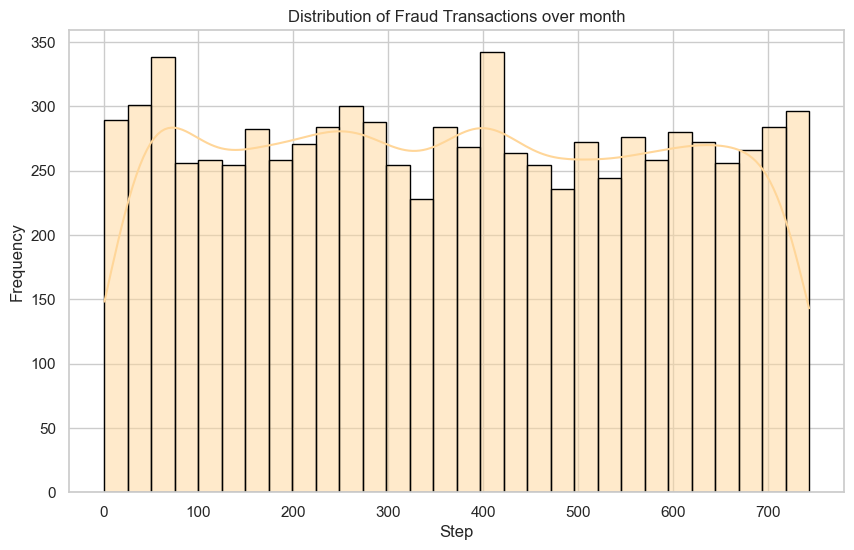

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_transactions["step"], bins=30, kde=True, color=light_orange, edgecolor='black')
plt.title('Distribution of Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

Interprétation:

Le graphique montre que les transactions frauduleuses se produisent de manière assez constante au fil du temps, certains pics indiquant des périodes d'activité frauduleuse légèrement plus élevée.
Il n’existe pas de période unique où les transactions frauduleuses augmentent considérablement, ce qui suggère que l’activité frauduleuse est quelque peu étalée dans le temps.

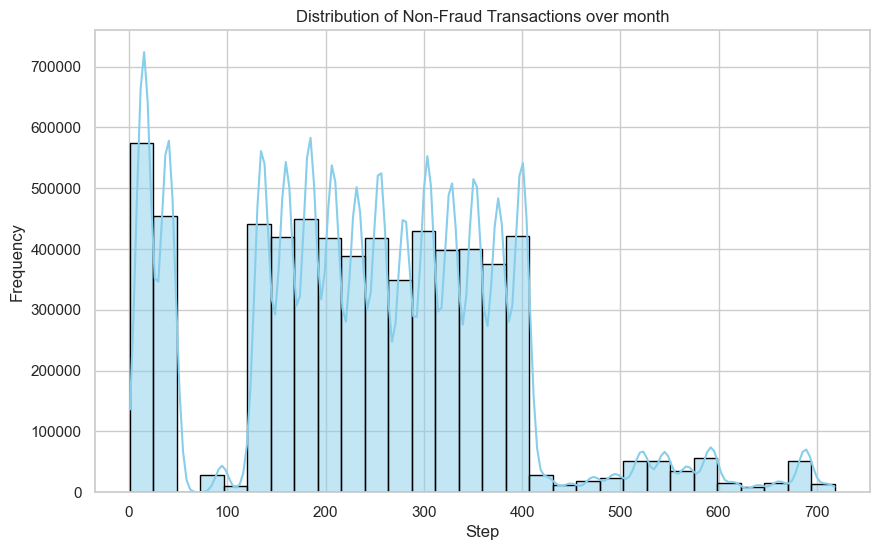

In [24]:
non_fraud_transactions = df[df["isFraud"] == 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_transactions["step"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

the distribution of fraudulent transactions over a period of time, specifically focusing on the "step" variable/column from the "fraud_transactions" dataset.
 The visualization helps in understanding the frequency or density of fraud occurrences across different steps or time intervals.
### 

Comparing the Two Graphs:
Fraud vs. Non-Fraud: The non-fraudulent transactions show a much higher overall frequency compared to fraudulent transactions, which is expected. Fraudulent transactions are relatively rare compared to the total volume of transactions.

Time Distribution: Fraudulent transactions are more evenly spread out over time, while non-fraud transactions have significant peaks and valleys, especially a large peak early on.

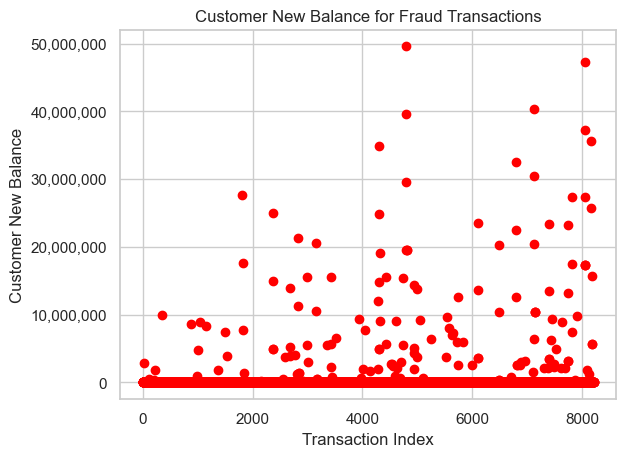

In [25]:
plt.scatter(range(len(fraud_transactions)), fraud_transactions['newbalanceOrig'], color='red')
plt.title('Customer New Balance for Fraud Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Customer New Balance')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

plt.show()

De nombreuses transactions frauduleuses sont liées à des clients dont le solde des comptes tombe ensuite à zéro. Ce modèle implique que les fraudeurs manipulent souvent les transactions pour épuiser ou minimiser les soldes des clients concernés. Détecter et surveiller les cas où des transactions importantes aboutissent à des soldes nuls est crucial pour prévenir et identifier la fraude. Comprendre ce modèle permet d'améliorer les mesures de sécurité et les protections contre les activités frauduleuses visant à vider les comptes clients.
### 

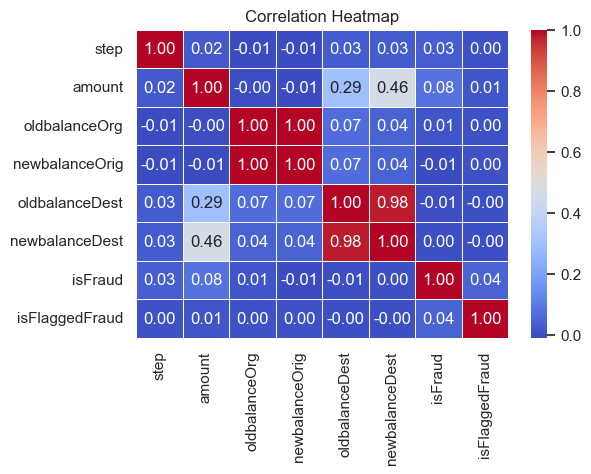

In [26]:
corr_matrix = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Même si Heatmap ne révèle pas de fortes corrélations avec la variable cible (isFraud), elle met en évidence une observation remarquable. Il existe une corrélation significative entre les nouveaux et les anciens soldes des comptes. Bien que la carte thermique ne puisse pas aider directement à comprendre les modèles de fraude, la reconnaissance de la corrélation entre certaines caractéristiques, telles que les anciens et les nouveaux soldes, peut s'avérer utile pour affiner l'ingénierie des fonctionnalités et développer des modèles plus nuancés pour la détection des fraudes.
### 

# Data processing(Traitement de l'information )

In [27]:
process_df = df.copy()
process_df.shape

(6362620, 11)

Pour faciliter le traitement et l'analyse des données sans altérer l'intégrité de l'ensemble de données d'origine, une copie du DataFrame a été créée et étiquetée process_df. Ce DataFrame dupliqué, process_df, sert de version de travail, permettant l'expérimentation et les modifications sans impacter l'ensemble de données d'origine désigné par la variable df. L'utilisation d'une copie garantit une protection contre les modifications involontaires de l'ensemble de données de base, fournissant un environnement structuré et contrôlé pour une exploration et une analyse plus approfondies.
### 

In [28]:
process_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.6",C1231006815,"170,136.0","160,296.4",M1979787155,0.0,0.0,0,0
1,1,PAYMENT,"1,864.3",C1666544295,"21,249.0","19,384.7",M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,"21,182.0",0.0,1,0
4,1,PAYMENT,"11,668.1",C2048537720,"41,554.0","29,885.9",M1230701703,0.0,0.0,0,0


In [29]:
process_df.drop('isFlaggedFraud', axis=1, inplace=True)


La colonne « isFlaggedFraud » a été supprimée du DataFrame process_df. Cette décision a été prise sur la base de l'évaluation selon laquelle la colonne n'a pas de sens dans le contexte de l'analyse actuelle et n'est pas pertinente pour notre cas d'utilisation spécifique. En le supprimant, nous rationalisons l'ensemble de données pour nous concentrer sur les fonctionnalités plus pertinentes par rapport aux objectifs de notre analyse, contribuant ainsi à un ensemble de données plus concis et plus ciblé.
### 

In [30]:
types_to_exclude = ['CASH_IN', 'DEBIT', 'PAYMENT']
process_df = process_df[~process_df['type'].isin(types_to_exclude)]

Pour optimiser l'ensemble de données et le rationaliser pour l'analyse, les transactions de types « CASH_IN », « DEBIT » et « PAYMENT » ont été exclues du dataFrame process_df. Cette décision repose sur le constat qu’il n’existe aucun cas de fraude associé à ces types de transactions. En excluant ces types, nous visons à minimiser les proportions des ensembles de données et à nous concentrer sur les catégories de transactions pertinentes pour l'identification et l'analyse des activités frauduleuses, améliorant ainsi l'efficacité des efforts ultérieurs de modélisation et d'analyse.
### 

In [31]:
print(f"Total count: {process_df.shape[0]}")

Total count: 2770409


Nous avons considérablement réduit l'ensemble de données, contenant désormais 2 770 409 entrées.

In [32]:
6362620-2770409


3592211

In [33]:
total_transactions = len(process_df)
wrong_org_balance = sum(process_df["oldbalanceOrg"] - process_df["amount"] != process_df["newbalanceOrig"])
wrong_dest_balance = sum(process_df["oldbalanceDest"] + process_df["amount"] != process_df["newbalanceDest"])
percentage_wrong_org_balance = (wrong_org_balance / total_transactions) * 100
percentage_wrong_dest_balance = (wrong_dest_balance / total_transactions) * 100

print(f"Percentage of wrong origin balances: {percentage_wrong_org_balance:.2f}%")
print(f"Percentage of wrong destination balances: {percentage_wrong_dest_balance:.2f}%")


Percentage of wrong origin balances: 93.72%
Percentage of wrong destination balances: 42.09%


Un nombre considérable de soldes de notre ensemble de données semblent inexacts. Cela suggère qu’une partie importante des transactions pourrait présenter des incohérences dans leurs soldes d’origine et de destination.
### 

In [34]:
process_df.loc[ (process_df["oldbalanceOrg"] == 0) | (process_df["oldbalanceOrg"] < process_df["amount"]), "oldbalanceOrg"] = process_df["amount"]
process_df["newbalanceOrg"] = process_df["oldbalanceOrg"] - process_df["amount"]
process_df["newbalanceDest"] = process_df["oldbalanceDest"] + process_df["amount"]

Pour rectifier les incohérences dans les soldes origine et destination, nous avons mis en place une approche de calcul dynamique. Voici un résumé concis :

Pour les transactions dont l'ancien solde d'origine est nul ou inférieur au montant de la transaction, nous définissons l'ancien solde d'origine pour qu'il soit égal au montant de la transaction.

Le nouveau solde d'origine est ensuite calculé comme la différence entre l'ancien solde d'origine et le montant de la transaction.

Le nouveau solde de destination est calculé en ajoutant le montant de la transaction à l'ancien solde de destination.

Ce recalcul dynamique à la volée garantit que les informations de solde dans l'ensemble de données sont plus précises, corrigeant les écarts et créant une base fiable pour les analyses et la modélisation ultérieures.
### 

In [35]:
process_df['isCustomerToCustomer'] = ((process_df['nameOrig'].str.startswith('C').astype(int) == 1) & (process_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)

Une nouvelle colonne binaire, 'isCustomerToCustomer', a été introduite dans le dataFrame process_df. Cette colonne est déterminée selon que les colonnes « nameOrg » et « nameDest » commencent par la lettre « C », signifiant clients. Les valeurs de cette colonne sont 1 pour les transactions entre clients et 0 sinon. Cet ajout vise à mettre en évidence les transactions impliquant spécifiquement les clients à la fois à l’envoi et à la réception.
### 

In [36]:
# Count rows where isCustomerToCustomer is 1 for each category of isFraud
count_by_fraud_customer_to_customer = process_df[process_df['isCustomerToCustomer'] == 1].groupby('isFraud').size()

print("Count of rows with isCustomerToCustomer = 1 by isFraud category:")
print(count_by_fraud_customer_to_customer)
print(f"Total count: {count_by_fraud_customer_to_customer.sum()}")

Count of rows with isCustomerToCustomer = 1 by isFraud category:
isFraud
0    2762196
1       8213
dtype: int64
Total count: 2770409


Après avoir filtré des types de transactions spécifiques, toutes les transactions restantes sont désormais classées comme « Client à client » dans l'ensemble de données. Les décomptes par catégorie « isFraud » confirment que chaque transaction entre dans cette catégorie. En conséquence, nous avons décidé de conserver la colonne « isCustomerToCustomer » dans l'ensemble de données car elle distingue la nature de toutes les transactions. Ces informations pourraient être utiles pour une analyse plus approfondie et pourraient contribuer à l’identification d’activités frauduleuses.
### 

In [37]:
process_df.drop(columns=['nameDest', 'nameOrig'], axis=1, inplace=True)

Les colonnes « nameDest » et « nameOrg » ont été supprimées du dataFrame process_df car elles ont été jugées inutiles pour l'analyse actuelle. Cette étape vise à rationaliser l'ensemble de données et à se concentrer sur des fonctionnalités plus pertinentes, améliorant ainsi l'efficacité des efforts d'analyse et de modélisation ultérieurs.
### 

In [38]:
process_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,newbalanceOrg,isCustomerToCustomer
2,1,TRANSFER,181.0,181.0,0.0,0.0,181.0,1,0.0,1
3,1,CASH_OUT,181.0,181.0,0.0,"21,182.0","21,363.0",1,0.0,1
15,1,CASH_OUT,"229,133.9","229,133.9",0.0,"5,083.0","234,216.9",0,0.0,1
19,1,TRANSFER,"215,310.3","215,310.3",0.0,"22,425.0","237,735.3",0,0.0,1
24,1,TRANSFER,"311,685.9","311,685.9",0.0,"6,267.0","317,952.9",0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,"339,682.1","339,682.1",0.0,0.0,"339,682.1",1,0.0,1
6362616,743,TRANSFER,"6,311,409.3","6,311,409.3",0.0,0.0,"6,311,409.3",1,0.0,1
6362617,743,CASH_OUT,"6,311,409.3","6,311,409.3",0.0,"68,488.8","6,379,898.1",1,0.0,1
6362618,743,TRANSFER,"850,002.5","850,002.5",0.0,0.0,"850,002.5",1,0.0,1


In [39]:
label_encoder = LabelEncoder()
process_df['type'] = label_encoder.fit_transform(process_df['type'])

In [40]:
process_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,newbalanceOrg,isCustomerToCustomer
2,1,1,181.0,181.0,0.0,0.0,181.0,1,0.0,1
3,1,0,181.0,181.0,0.0,"21,182.0","21,363.0",1,0.0,1
15,1,0,"229,133.9","229,133.9",0.0,"5,083.0","234,216.9",0,0.0,1
19,1,1,"215,310.3","215,310.3",0.0,"22,425.0","237,735.3",0,0.0,1
24,1,1,"311,685.9","311,685.9",0.0,"6,267.0","317,952.9",0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,743,0,"339,682.1","339,682.1",0.0,0.0,"339,682.1",1,0.0,1
6362616,743,1,"6,311,409.3","6,311,409.3",0.0,0.0,"6,311,409.3",1,0.0,1
6362617,743,0,"6,311,409.3","6,311,409.3",0.0,"68,488.8","6,379,898.1",1,0.0,1
6362618,743,1,"850,002.5","850,002.5",0.0,0.0,"850,002.5",1,0.0,1


Cette transformation attribue des étiquettes numériques aux différents types de transactions, convertissant les données catégorielles dans un format adapté aux modèles d'apprentissage automatique. Le LabelEncoder aide à la représentation numérique de la colonne « type », facilitant son incorporation dans des algorithmes pour une analyse ultérieure et la formation du modèle.
### 

In [41]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']


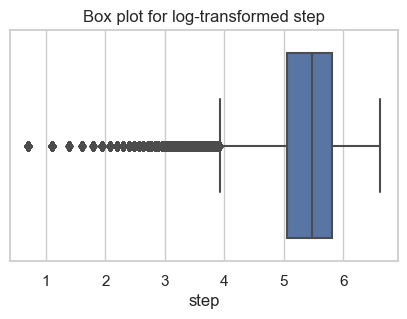

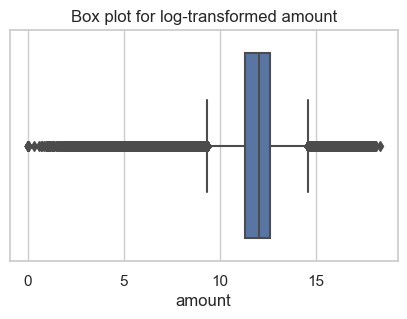

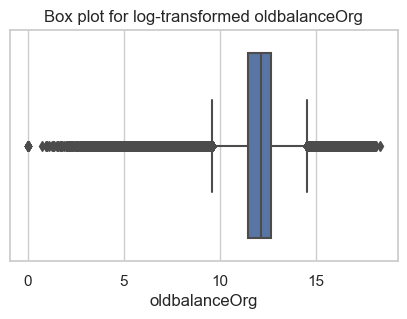

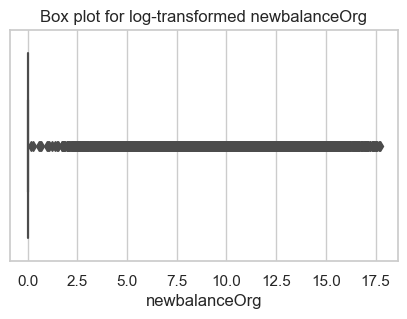

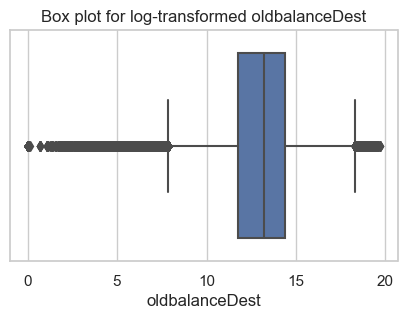

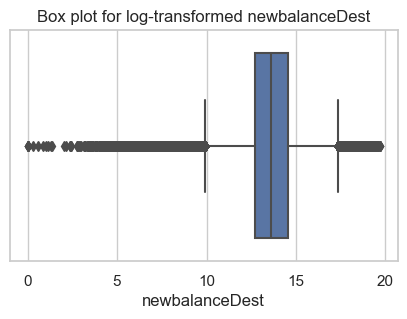

In [42]:
for column in numeric_columns:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=np.log1p(process_df[column]))  # Applying log transformation
    plt.title(f'Box plot for log-transformed {column}')
    plt.show()

Les colonnes 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest' et 'newbalanceDest' ont été transformées en journal à l'aide de np.log1p() pour rendre les distributions plus symétriques.

La sortie présente les valeurs log-transformées pour chaque colonne, et les boîtes à moustaches suivantes représentent visuellement la distribution de ces valeurs log-transformées. Il est important de noter que les diagrammes en boîte sont basés sur des valeurs transformées en log pour une meilleure visualisation et une détection des valeurs aberrantes.

La présence de nombreux points hors de la boîte dans les diagrammes en boîte indique l’existence potentielle de valeurs aberrantes ou extrêmes. Ces valeurs aberrantes peuvent s'écarter considérablement de la majorité des données et avoir un impact sur les processus d'analyse statistique ou de modélisation.
### 

In [43]:
for column in numeric_columns:
    column_data = process_df[column]
    column_iqr = iqr(column_data)
    print(f"IQR for {column}: {column_iqr}")

IQR for step: 177.0
IQR for amount: 223817.64
IQR for oldbalanceOrg: 231324.15999999997
IQR for newbalanceOrg: 0.0
IQR for oldbalanceDest: 1607826.7
IQR for newbalanceDest: 1765652.54


The Interquartile Range (IQR) is a measure of statistical dispersion. It’s calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of a dataset. Essentially, it gives you an idea of the range in which the central 50% of your data falls.

In summary, columns like amount, oldbalanceOrg, oldbalanceDest, and newbalanceDest have wide spreads in their central 50%, indicating high variability. In contrast, newbalanceOrg has no spread, suggesting uniformity.

In [44]:
for column in numeric_columns:
    process_df[column] = np.log1p(process_df[column])

robust_scaler = RobustScaler()
process_df[numeric_columns] = robust_scaler.fit_transform(process_df[numeric_columns])

Le RobustScaler est utilisé pour mettre à l'échelle les fonctionnalités en fonction de la plage interquartile (IQR), garantissant ainsi la robustesse face aux valeurs aberrantes. Ce scaler est particulièrement utile lorsqu'il s'agit de données contenant des valeurs aberrantes, car il exploite la médiane et l'IQR pour la mise à l'échelle plutôt que la moyenne et l'écart type.

Dans ce scénario spécifique, la transformation log1p est appliquée aux données, traitant les cas où l'IQR est de 0, permettant ainsi un mécanisme de mise à l'échelle plus robuste. La combinaison de log1p et de RobustScaler contribue aux étapes de prétraitement, améliorant la distribution des données et fournissant une approche de mise à l'échelle résiliente adaptée aux fonctionnalités présentant des valeurs aberrantes potentielles.
### 

Log Transformation: Reduces skewness(l'asymétrie) and compresses the range of values.
Robust Scaling: Normalizes the data using statistics that are less influenced by outliers.

In [45]:
process_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,newbalanceOrg,isCustomerToCustomer
2,-6.3,1,-5.2,-5.6,0.0,-5.1,-4.5,1,0.0,1
3,-6.3,0,-5.2,-5.6,0.0,-1.3,-2.0,1,0.0,1
15,-6.3,0,0.2,0.2,0.0,-1.8,-0.7,0,0.0,1
19,-6.3,1,0.2,0.1,0.0,-1.2,-0.7,0,0.0,1
24,-6.3,1,0.5,0.4,0.0,-1.7,-0.5,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,1.5,0,0.5,0.5,0.0,-5.1,-0.5,1,0.0,1
6362616,1.5,1,2.8,2.8,0.0,-5.1,1.1,1,0.0,1
6362617,1.5,0,2.8,2.8,0.0,-0.8,1.1,1,0.0,1
6362618,1.5,1,1.2,1.2,0.0,-5.1,0.0,1,0.0,1


## Évaluation de différents modèles

In [46]:
process_df=process_df.rename(columns={'type':'Type'})
process_df

,step,Type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,newbalanceOrg,isCustomerToCustomer
2,-6.3,1,-5.2,-5.6,0.0,-5.1,-4.5,1,0.0,1
3,-6.3,0,-5.2,-5.6,0.0,-1.3,-2.0,1,0.0,1
15,-6.3,0,0.2,0.2,0.0,-1.8,-0.7,0,0.0,1
19,-6.3,1,0.2,0.1,0.0,-1.2,-0.7,0,0.0,1
24,-6.3,1,0.5,0.4,0.0,-1.7,-0.5,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,1.5,0,0.5,0.5,0.0,-5.1,-0.5,1,0.0,1
6362616,1.5,1,2.8,2.8,0.0,-5.1,1.1,1,0.0,1
6362617,1.5,0,2.8,2.8,0.0,-0.8,1.1,1,0.0,1
6362618,1.5,1,1.2,1.2,0.0,-5.1,0.0,1,0.0,1


In [47]:
process_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   step                  float64
 1   Type                  int32  
 2   amount                float64
 3   oldbalanceOrg         float64
 4   newbalanceOrig        float64
 5   oldbalanceDest        float64
 6   newbalanceDest        float64
 7   isFraud               int64  
 8   newbalanceOrg         float64
 9   isCustomerToCustomer  int32  
dtypes: float64(7), int32(2), int64(1)
memory usage: 275.9 MB


In [48]:
X = process_df[['step', 'Type', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']]
Y = process_df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [49]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float64
 1   Type            int32  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrg   float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
dtypes: float64(6), int32(1)
memory usage: 223.0 MB


In [50]:
process_df.drop('isCustomerToCustomer', axis=1, inplace=True)

In [51]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Dans les tâches de classification avec des données déséquilibrées, 
#### StratifiedKFold est avantageux pour la validation croisée. 
Il divise les données de manière aléatoire en k plis tout en conservant les proportions de classe, favorisant ainsi la formation de modèles sur un échantillon représentatif. Le paramètre shuffle=True garantit un brassage aléatoire des données avant la création du pli, ce qui est utile pour éviter les biais introduits par l'ordre des données d'origine.
### 

In [52]:
logreg_model = LogisticRegression(random_state=42)

  Logistic Regression is a classification algorithm used for predicting binary outcomes
  ##### 

In [53]:
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, Y_train)

Le but de l'utilisation de SMOTE ici est de créer des exemples synthétiques supplémentaires de la classe minoritaire (transactions frauduleuses) dans les données de formation. Cela permet d'éviter que le modèle ne soit biaisé en faveur de la classe majoritaire (transactions non frauduleuses) pendant la formation, améliorant ainsi sa capacité à détecter les modèles frauduleux.
### 

In [54]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score), 
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='f1', return_train_score=True)
grid_search.fit(X_train_over_sampled, y_train_over_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

Le solveur LBFGS ne prend en charge que les pénalités « l2 » ou « aucune ». Avec l1, une erreur se produit.

La recherche dans la grille optimisera les hyperparamètres en fonction à la fois du score F1, du score ROC AUC et du rappel.

Le modèle final ajusté sera celui qui aura obtenu
###### le score F1 le plus élevé lors du processus de validation croisée.


In [55]:
X_train_over_sampled.value_counts()
y_train_over_sampled.value_counts()

0    2209757
1     220975
Name: isFraud, dtype: int64

RandomUnderSampler: Reduces the number of samples in the majority class to balance the class distribution.

In [56]:
print("Class distribution before random undersampling:")
print(Y_train.value_counts())

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train_under_sampled, y_train_under_sampled = undersampler.fit_resample(X_train, Y_train)

print("\nClass distribution after random undersampling:")
print(y_train_under_sampled.value_counts())

Class distribution before random undersampling:
0    2209757
1       6570
Name: isFraud, dtype: int64

Class distribution after random undersampling:
0    65700
1     6570
Name: isFraud, dtype: int64


In [57]:
grid_search_sampled = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='roc_auc', return_train_score=True)
grid_search_sampled.fit(X_train_under_sampled, y_train_under_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring={'f1': make_scorer(f1_score),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score)})

Train again with undersampled data
### 

In [58]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Before under sampling:")
print("   Best Hyperparameters:", best_params)
print("   Best Score:", best_score)

best_params_sampled = grid_search_sampled.best_params_
best_score_sampled = grid_search_sampled.best_score_

print("After under sampling:")
print("   Best Hyperparameters:", best_params_sampled)
print("   Best Score:", best_score_sampled)

Before under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.4433201731547515
After under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.6526027397260273


In [59]:
best_logistic_over_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_over_sampled.fit(X_train_over_sampled, y_train_over_sampled)

LogisticRegression(C=10, random_state=42)

In [60]:
best_logistic_under_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_under_sampled.fit(X_train_under_sampled, y_train_under_sampled)

LogisticRegression(C=10, random_state=42)

In [61]:
y_pred = best_logistic_over_sampled.predict(X_test)
predicted_probabilities = best_logistic_over_sampled.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print("Oversampled:")
print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

y_pred_sampled = best_logistic_under_sampled.predict(X_test)
predicted_probabilities_sampled = best_logistic_under_sampled.predict_proba(X_test)
mcc_sampled = matthews_corrcoef(Y_test, y_pred_sampled)
print("\nUndersampled:")
print(classification_report(Y_test, y_pred_sampled))
print(f'Matthews Correlation Coefficient: {mcc_sampled:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities_sampled[:, 1]):.2f}')

Oversampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.33      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.16
ROC-AUC Score: 0.84

Undersampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.32      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.15
ROC-AUC Score: 0.84


[[546163   6276]
 [  1108    535]]


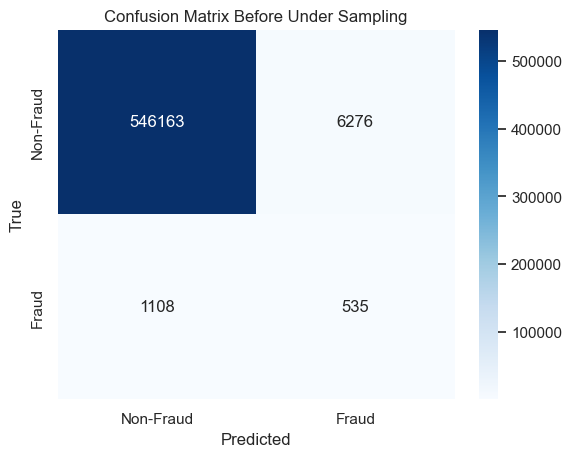

[[546159   6280]
 [  1110    533]]


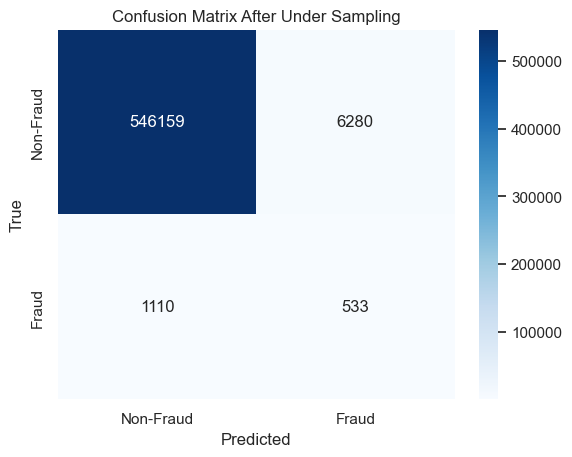

In [62]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
plot_confusion_matrix(Y_test, y_pred, 'Confusion Matrix Before Under Sampling')
plot_confusion_matrix(Y_test, y_pred_sampled, 'Confusion Matrix After Under Sampling')
plt.show()

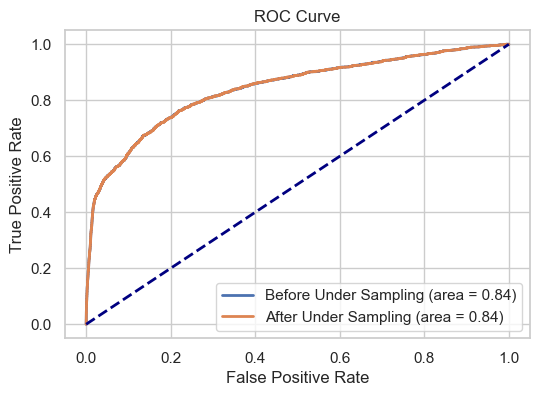

In [63]:
def plot_roc_curve(Y_test, predicted_probabilities, label):
    fpr, tpr, _ = roc_curve(Y_test, predicted_probabilities[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

plt.figure(figsize=(6, 4))
plot_roc_curve(Y_test, predicted_probabilities, 'Before Under Sampling')
plot_roc_curve(Y_test, predicted_probabilities_sampled, 'After Under Sampling')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [64]:
rf_model = RandomForestClassifier(random_state=42)

In [65]:
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}
random_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': 'balanced'}


In [66]:
best_params = random_search.best_params_
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_under_sampled, y_train_under_sampled)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200)

In [67]:
y_pred = best_rf_model.predict(X_test)
predicted_probabilities = best_rf_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    552439
           1       0.07      0.82      0.13      1643

    accuracy                           0.97    554082
   macro avg       0.53      0.89      0.55    554082
weighted avg       1.00      0.97      0.98    554082

Matthews Correlation Coefficient: 0.23
ROC-AUC Score: 0.96


[[534044  18395]
 [   302   1341]]


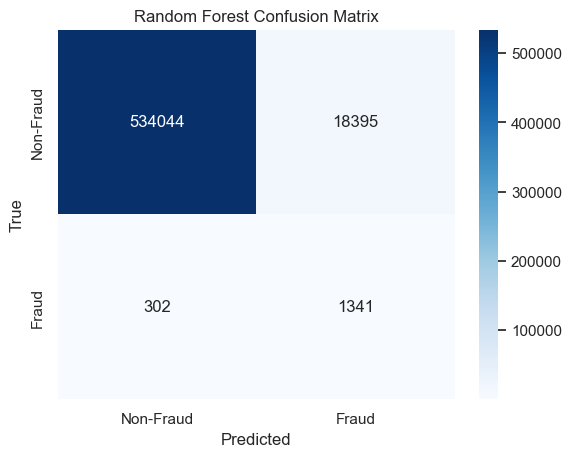

In [68]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

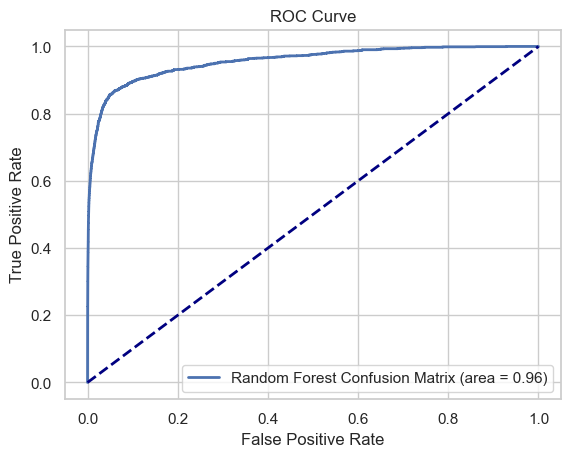

In [69]:
plot_roc_curve(Y_test, predicted_probabilities, 'Random Forest Confusion Matrix')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

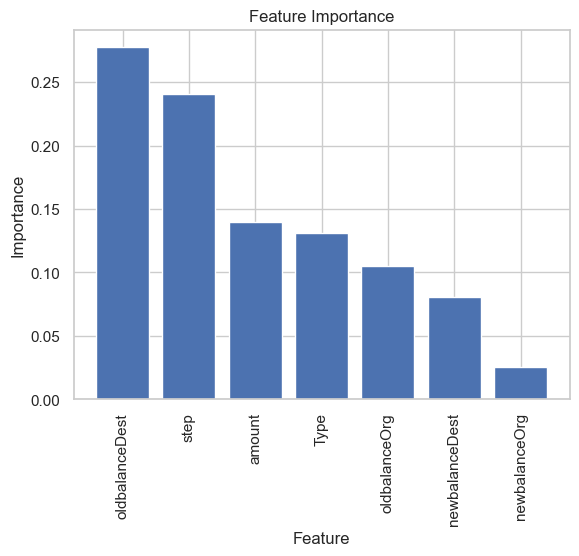

In [70]:
feature_importances = random_search.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(X_train_under_sampled.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train_under_sampled.shape[1]), X_train_under_sampled.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

Matthews Correlation Coefficient (MCC): The MCC is 0.16, indicating a moderate correlation between predicted and actual classes. 

In [71]:
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1] 
}
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

# Fit the model to your training data
random_search_xgb.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'alpha': [0, 0.1, 0.5, 1],
                                        'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                    

In [76]:
import joblib

# Save the model to a file
joblib.dump( best_rf_model, 'frauddetection.pkl')

['frauddetection.pkl']

In [73]:
# To load a .pkl file
model = joblib.load('frauddetection.pkl')

In [74]:
import pickle

with open('frauddetection.pkl', 'rb') as file:
    data = pickle.load(file)


In [75]:
# Display the type and a summary of the data
print(type(data))  # This will tell you what type of object was loaded
print(data)        # This will print the data itself

<class 'numpy.ndarray'>
['step' 'Type' 'amount' 'oldbalanceOrg' 'newbalanceOrg' 'oldbalanceDest'
 'newbalanceDest']
